In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import string

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from wordcloud import WordCloud

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE

# Observations

In [3]:
# Load Data, Initialize Dataframe
imdb_reviews_df = pd.read_csv('imdb_reviews.csv')

In [4]:
imdb_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
imdb_reviews_df.head(10)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1


In [6]:
# Add new Column with Descriptive Value of Label
label_dict = {0:'Negative', 1:'Positive'}
imdb_reviews_df['emotion'] = imdb_reviews_df['label'].map(label_dict)

In [22]:
# Drop old label columns
imdb_reviews_df.drop('label', axis=1, inplace=True)

In [23]:
imdb_reviews_df.head(10)

,text,emotion
0,grew b watching loving thunderbird mate school...,Negative
1,put movie dvd player sat coke chip expectation...,Negative
2,people know particular time past like feel nee...,Negative
3,even though great interest biblical movie bore...,Negative
4,im die hard dad army fan nothing ever change g...,Positive
5,terrible movie everyone said made laugh cameo ...,Negative
6,finally watched shocking movie last night dist...,Positive
7,caught film azn cable sounded like would good ...,Negative
8,may remake autumn's tale eleven year director ...,Positive
9,super ex girlfriend turned pleasant surprise r...,Positive


In [9]:
imdb_reviews_df['emotion'].value_counts()

Negative    20019
Positive    19981
Name: emotion, dtype: int64

# Text Processing

In order for the text from the movie reviews to be useful for Sentiment Analysis modeling and predictions, we need to clean it up by applying the following transformations:

1. Removal of special characters that could confuse the models and standardization of capitilization
2. Tokenization using RegexpTokenizer
3. Lemmatization of the Tokens
4. Removal of stopwords and modification of stopword library if needed

I will create a function that takes in the text as is from the dataset and returns a cleaned format

In [13]:
def text_cleaning(text):
    """
    Args:
        text(string): The text from which punctuation, stopwords are removed and lemmatized
        
    Returns:
        clean_text(string): A text formed after text preprocessing.
    """
    
    # Remove any urls from the text
    text = re.sub(r'https:\/\/.*[\r\n]*',
                  "",
                  str(text))
    
    # Remove any urls starting from www. in the text
    text = re.sub(r'www\.\w*\.\w\w\w',
                  "",
                  str(text))
    
    # Remove any html elements from the text
    text = re.sub(r"<[\w]*[\s]*/>",
                  "",
                  str(text))
    
    # Remove periods
    text = re.sub(r"[\.]*",
                  "",
                  str(text))
    
 
    # Initialize RegexpTokenizer
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    tokenizer = RegexpTokenizer(pattern)

    
    # Tokenize text
    text_tokens = tokenizer.tokenize(text.lower())
    
    lemmatizer  = WordNetLemmatizer()
    # Get english stopwords
    english_stopwords = stopwords.words("english")
    
    cleaned_text_tokens = [] # A list to hold cleaned text tokens
    
    for word in text_tokens:
        if((word not in english_stopwords) and # Remove stopwords
            (word not in string.punctuation)): # Remove punctuation marks
                
                lemmas = lemmatizer.lemmatize(word) # Get lemma of the current word
                cleaned_text_tokens.append(lemmas) # Appened lemma word to list of cleaned list
    
    # Combine list into single string
    clean_text = " ".join(cleaned_text_tokens)
    
    return clean_text

In [14]:
imdb_reviews_df['text'] = imdb_reviews_df['text'].apply(text_cleaning)

In [15]:
imdb_reviews_df['text']

0        grew b watching loving thunderbird mate school...
1        put movie dvd player sat coke chip expectation...
2        people know particular time past like feel nee...
3        even though great interest biblical movie bore...
4        im die hard dad army fan nothing ever change g...
                               ...                        
39995    western union something forgotten classic west...
39996    movie incredible piece work explores every noo...
39997    wife watched movie plan visit sicily stromboli...
39998    first watched flatliners amazed necessary feat...
39999    would film good gross estimated award nominati...
Name: text, Length: 40000, dtype: object

In [21]:
imdb_reviews_df.head(10)

,text,label,emotion
0,grew b watching loving thunderbird mate school...,0,Negative
1,put movie dvd player sat coke chip expectation...,0,Negative
2,people know particular time past like feel nee...,0,Negative
3,even though great interest biblical movie bore...,0,Negative
4,im die hard dad army fan nothing ever change g...,1,Positive
5,terrible movie everyone said made laugh cameo ...,0,Negative
6,finally watched shocking movie last night dist...,1,Positive
7,caught film azn cable sounded like would good ...,0,Negative
8,may remake autumn's tale eleven year director ...,1,Positive
9,super ex girlfriend turned pleasant surprise r...,1,Positive


### Sentiment Score

I will be calculating a sentiment score in order to contextualize how strong the opinions behind each review are using the following steps:
1. Calculate total length of each review (in characters)
2. Count the number of positive and negative words in each review using the 'Opinion Lexicon' found here: 
https://www.kaggle.com/datasets/nltkdata/opinion-lexicon
3. Take the difference of positive and negative words and divide it by the review length

In [32]:
# Add column for total review length (characters)
imdb_reviews_df['review_length'] = imdb_reviews_df['text'].map(lambda x: len(x))

In [38]:
# 
file = open('./appendix/negative-words.txt', 'r')
neg_words = file.read().split()
file = open('./appendix/positive-words.txt', 'r')
pos_words = file.read().split()

In [39]:
num_pos = imdb_reviews_df['text'].map(lambda x: len([i for i in x if i in pos_words]))
imdb_reviews_df['positive_word_count'] = num_pos
num_neg = imdb_reviews_df['text'].map(lambda x: len([i for i in x if i in neg_words]))
imdb_reviews_df['negative_word_count'] = num_neg
imdb_reviews_df['sentiment_score'] = round((imdb_reviews_df['positive_word_count'] - imdb_reviews_df['negative_word_count']) / imdb_reviews_df['review_length'], 2)
imdb_reviews_df.head()

,text,emotion,review_length,positive_word_count,negative_word_count,sentiment_score
0,grew b watching loving thunderbird mate school...,Negative,596,36,36,0.0
1,put movie dvd player sat coke chip expectation...,Negative,1086,60,60,0.0
2,people know particular time past like feel nee...,Negative,619,37,37,0.0
3,even though great interest biblical movie bore...,Negative,211,14,14,0.0
4,im die hard dad army fan nothing ever change g...,Positive,633,46,46,0.0


In [41]:
imdb_reviews_df['sentiment_score'].value_counts()

0.0    40000
Name: sentiment_score, dtype: int64

### Train Test Split and Vectorization

In [17]:
X = imdb_reviews_df.text
y = imdb_reviews_df.emotion

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 24)

In [18]:
tf_idf = TfidfVectorizer()

X_train = tf_idf.fit_transform(X_train.tolist())
X_test = tf_idf.transform(X_test.tolist())

In [19]:
print(X_train.shape, X_test.shape)

(24000, 97391) (16000, 97391)


In [20]:
# LabelEncode
label_encoder = preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### Baseline (Dummy) Model

              precision    recall  f1-score   support

    Negative       0.50      1.00      0.67      7990
    Positive       0.00      0.00      0.00      8010

    accuracy                           0.50     16000
   macro avg       0.25      0.50      0.33     16000
weighted avg       0.25      0.50      0.33     16000



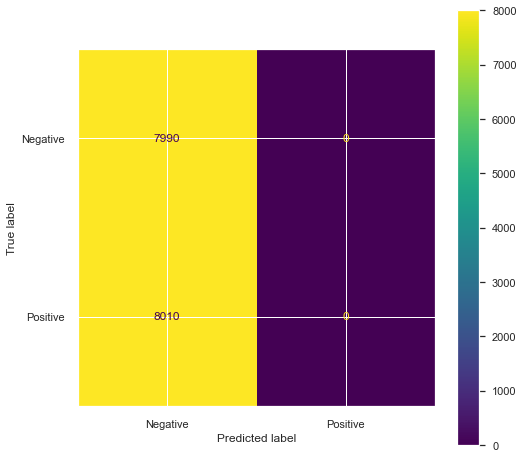

In [15]:
estimator = DummyClassifier(strategy='most_frequent')
estimator.fit(X_train, y_train)

# Get predictions with dummy model
y_pred = estimator.predict(X_test)

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Negative', 'Positive']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=estimator,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/Confusion_Matrix_Dummy');

target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred, target_names=target_names))

### Logistic Regression

Fitting 30 folds for each of 15 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  2.1min finished


Mean Training Score: 92.73%

Mean Test Score: 88.75%

Optimal Parameters: {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}

Testing Accuracy: 88.86%

              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      7990
    Positive       0.88      0.90      0.89      8010

    accuracy                           0.89     16000
   macro avg       0.89      0.89      0.89     16000
weighted avg       0.89      0.89      0.89     16000



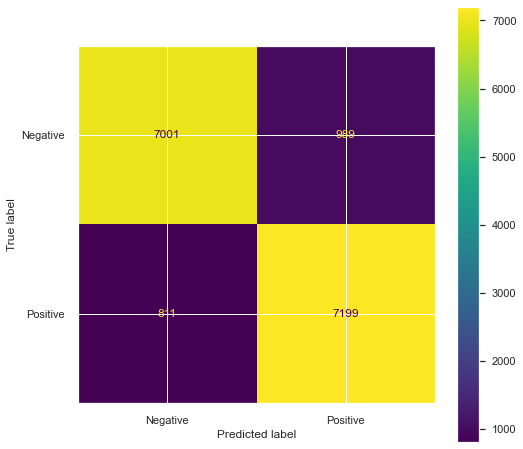

In [16]:
pipe = ImPipeline(steps=[
    ('estimator', LogisticRegression(random_state=42))
])

param_grid = {}
param_grid['estimator__C'] = [100, 10, 1.0, 0.1, 0.01]
param_grid['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['estimator__penalty'] = ['l2']

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=2)

# Fit models run gridsearch
grid_search.fit(X_train, y_train)

# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

# Set figsize and font scale
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(font_scale=1)

# Set diply labesl for confusion matrix
display_labels = ['Negative', 'Positive']

# Plot a confusion matrix on the test data
plot_confusion_matrix(estimator=best_grid,
                      X=X_test,
                      y_true=y_test,
                      display_labels=display_labels)


target_names = ['Negative', 'Positive']
print(classification_report(y_test, y_pred, target_names=target_names))

# Save confusion matrix as png and place it in the images folder
plt.savefig('images/LogReg_Model');